In [7]:
from IPython.core.interactiveshell import InteractiveShell; InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML;  display(HTML('<style>.container { width:95% !important; }</style>'))

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import xgboost as xgb # colab
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.base import TransformerMixin, BaseEstimator, clone
from imblearn.over_sampling import SMOTE

In [9]:
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 50)

# Data exploration

In [10]:
# colab
# from google.colab import drive
# drive.mount('/content/drive')
# df_weather_aus = pd.read_csv('/content/drive/MyDrive/kurs_Data_Science_2022/rain_in_australia/weatherAUS.csv')

In [11]:
df_weather_aus = pd.read_csv('weatherAUS.csv')

In [12]:
df_weather_aus.shape

(145460, 23)

In [13]:
df_weather_aus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [14]:
df_weather_aus.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [15]:
for col in df_weather_aus.columns:
    print(f'{col}: {df_weather_aus[col].nunique()} unique values')

Date: 3436 unique values
Location: 49 unique values
MinTemp: 389 unique values
MaxTemp: 505 unique values
Rainfall: 681 unique values
Evaporation: 358 unique values
Sunshine: 145 unique values
WindGustDir: 16 unique values
WindGustSpeed: 67 unique values
WindDir9am: 16 unique values
WindDir3pm: 16 unique values
WindSpeed9am: 43 unique values
WindSpeed3pm: 44 unique values
Humidity9am: 101 unique values
Humidity3pm: 101 unique values
Pressure9am: 546 unique values
Pressure3pm: 549 unique values
Cloud9am: 10 unique values
Cloud3pm: 10 unique values
Temp9am: 441 unique values
Temp3pm: 502 unique values
RainToday: 2 unique values
RainTomorrow: 2 unique values


In [16]:
# Quantity of missing values in 'RainTomorrow' (target) and 'RainToday' feature
# ('RainToday' feature is connected with 'RainTomorrow')
print(f'RainTomorrow has: {(df_weather_aus["RainTomorrow"].isna().sum() / df_weather_aus.shape[0]).round(2)} missing values.')
print(f'RainToday has: {(df_weather_aus["RainToday"].isna().sum() / df_weather_aus.shape[0]).round(2)} missing values.')

RainTomorrow has: 0.02 missing values.
RainToday has: 0.02 missing values.


In [17]:
# Let's drop observations with missing values in 'RainToday' and 'RainTomorrow'
df_weather_aus.dropna(how='any', subset='RainTomorrow', inplace=True)
df_weather_aus.dropna(how='any', subset='RainToday', inplace=True)

In [18]:
# Shape of dataframe after droping some observations
df_weather_aus.shape

(140787, 23)

In [19]:
df_weather_aus.isna().mean()

Date             0.000000
Location         0.000000
MinTemp          0.003324
MaxTemp          0.002181
Rainfall         0.000000
Evaporation      0.424002
Sunshine         0.474511
WindGustDir      0.065084
WindGustSpeed    0.064672
WindDir9am       0.068614
WindDir3pm       0.026068
WindSpeed9am     0.007494
WindSpeed3pm     0.017978
Humidity9am      0.010775
Humidity3pm      0.024867
Pressure9am      0.097616
Pressure3pm      0.097800
Cloud9am         0.373792
Cloud3pm         0.398432
Temp9am          0.004660
Temp3pm          0.018638
RainToday        0.000000
RainTomorrow     0.000000
dtype: float64

In [20]:
# binary encoding of 'RainTomorrow' target
df_weather_aus['RainTomorrow'] = df_weather_aus['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [21]:
# As we can see, 'RainTomorrow' target is imbalanced
df_weather_aus['RainTomorrow'].value_counts(normalize=True)

0    0.778382
1    0.221618
Name: RainTomorrow, dtype: float64

In [22]:
df_weather_aus['Date'].min()      # earliest observation date
df_weather_aus['Date'].max()      # latest observation date

'2007-11-01'

'2017-06-25'

In [23]:
categorical_features = df_weather_aus.select_dtypes(include='object').columns.to_list()
# for now let's exclude 'Date', from list - we will handle it later
categorical_features = [cat for cat in categorical_features if cat != 'Date']

numerical_features = df_weather_aus.select_dtypes(include=['int', 'float']).columns.to_list()
# let's exclude 'RainTomorrow' target from list
numerical_features = [feature for feature in numerical_features if feature != 'RainTomorrow']

In [24]:
categorical_features
numerical_features

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [25]:
# there is no major imbalance in categorical features
for feature in categorical_features:
    print(f'{feature} - least frequent: {df_weather_aus[feature].value_counts().min()}, most frequent: {df_weather_aus[feature].value_counts().max()}')

Location - least frequent: 1502, most frequent: 3402
WindGustDir - least frequent: 6372, most frequent: 9696
WindDir9am - least frequent: 6786, most frequent: 11266
WindDir3pm - least frequent: 6373, most frequent: 10578
RainToday - least frequent: 31455, most frequent: 109332


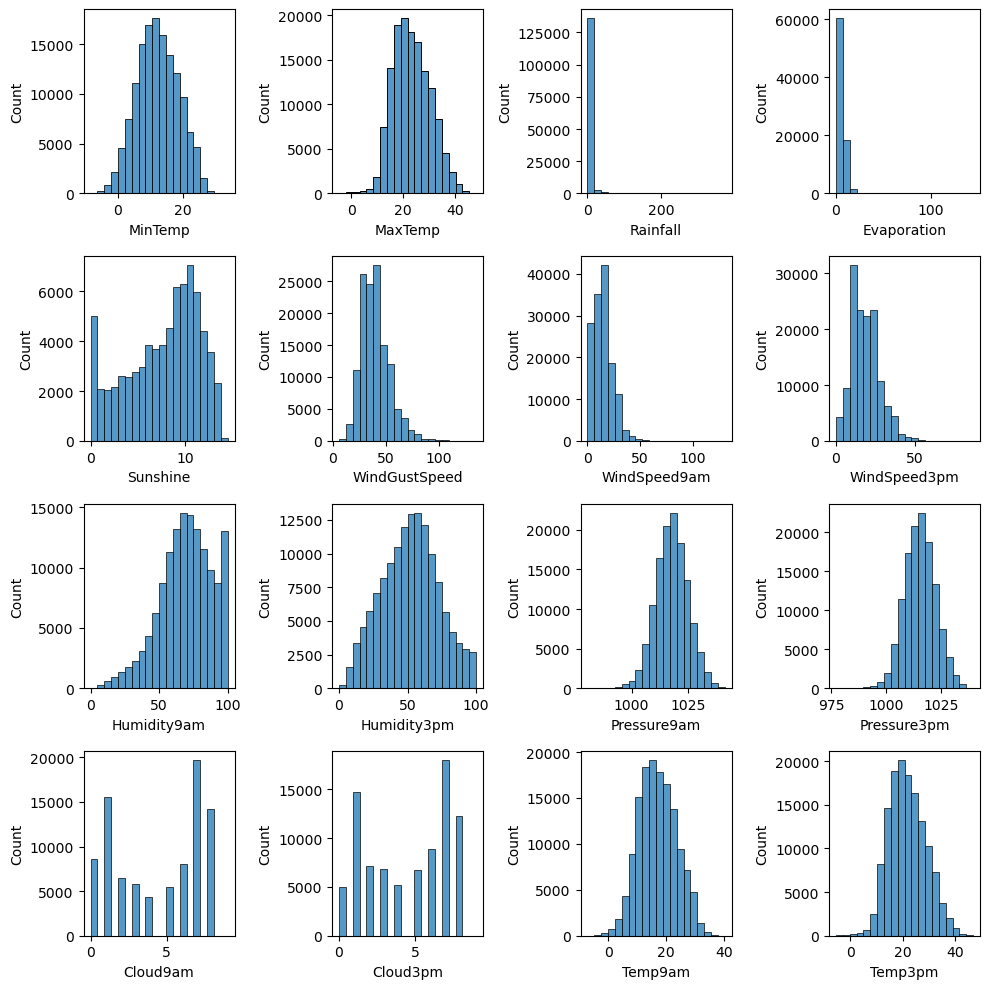

In [166]:
plt.figure(figsize=(10,10))
for idx, feature in enumerate(numerical_features):
    plt.subplot(4, 4, idx+1)
    sns.histplot(X[feature], bins=20)
    plt.tight_layout()
    
plt.show();

,lower_boundaries,upper_boundaries,outliers_observations_ratio,num_of_outliers
Rainfall,0.0,2.0,0.179193,25228.0
Evaporation,0.0,14.6,0.013829,1947.0
WindGustSpeed,5.5,73.5,0.021039,2962.0
WindSpeed9am,0.0,37.0,0.012182,1715.0
WindSpeed3pm,0.0,40.5,0.017189,2420.0
Humidity9am,18.0,122.0,0.010044,1414.0


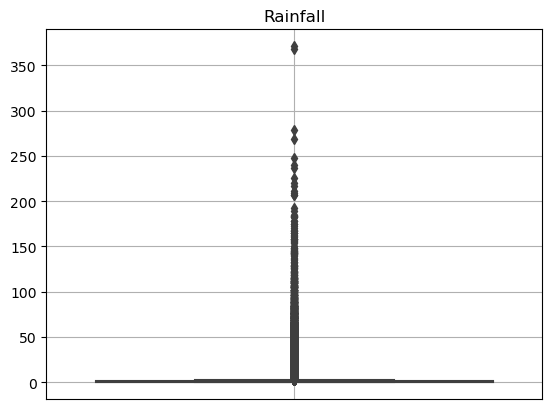

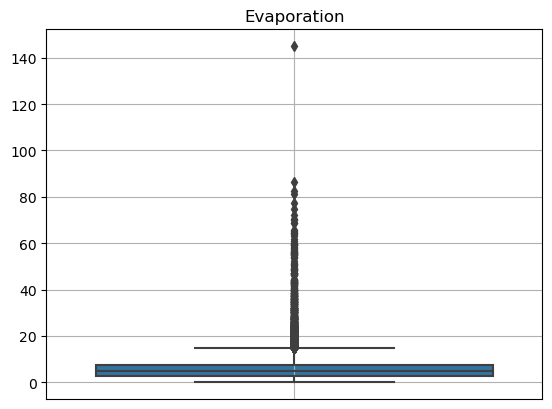

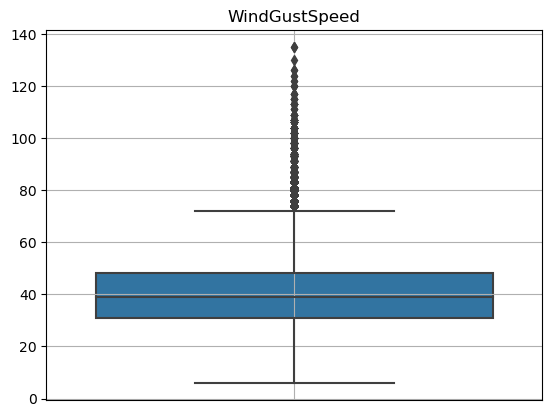

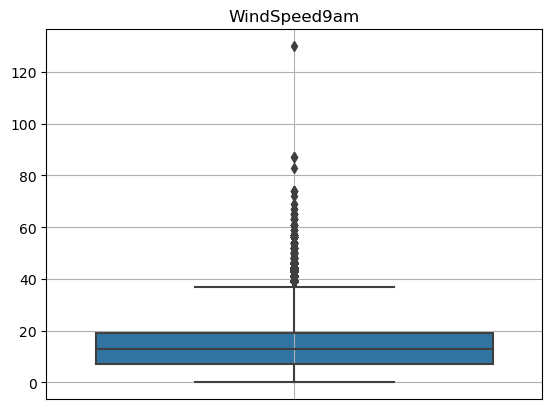

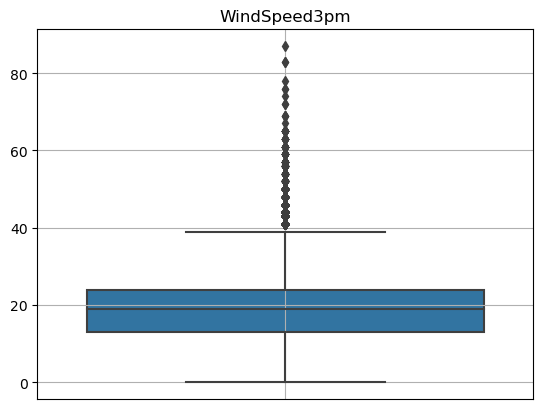

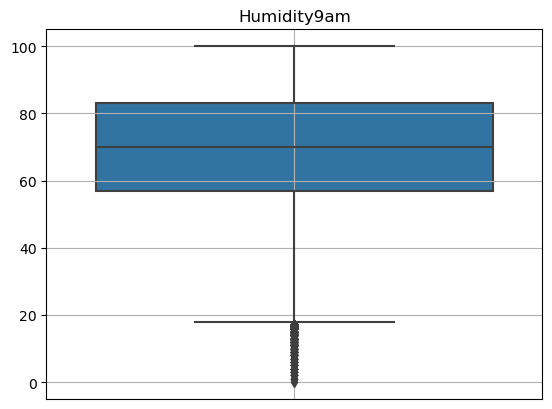

In [168]:
handle_outliers(df_weather_aus, numerical_features, method='iqr', use_for_analysis=True, out_obs_threshold=0.01)

In [167]:
handle_outliers(df_weather_aus, numerical_features, method='percentile_5_95', use_for_analysis=True, out_obs_threshold=0.09)

,lower_boundaries,upper_boundaries,outliers_observations_ratio,num_of_outliers
MinTemp,1.800,23.0,0.098766,13905.0
MaxTemp,12.895,35.5,0.098397,13853.0
Humidity9am,34.000,98.0,0.091123,12829.0
Temp9am,6.900,28.2,0.097253,13692.0
Temp3pm,11.500,33.7,0.095243,13409.0


In [27]:
X = df_weather_aus.drop(columns='RainTomorrow')
y = df_weather_aus['RainTomorrow']

# Functions, Transformers

In [113]:
def handle_outliers(df, features, method='iqr', use_for_analysis=False, out_obs_threshold=0.05):
    outliers_stats = {}
    
    for feature in features:
        values = df[feature]
        outliers_stats[feature] = []
        
        if method == 'iqr':
            q1 = values.quantile(0.25)
            q3 = values.quantile(0.75)
            iqr = q3 - q1
            lower_boundary = q1 - 1.5 * iqr
            upper_boundary = q3 + 1.5 * iqr
            
        elif method == 'percentile_5_95':
            lower_boundary = values.quantile(0.05)
            upper_boundary = values.quantile(0.95)
        
        if feature not in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'] and lower_boundary < 0:
            lower_boundary = 0
        
        outliers_stats[feature].extend([lower_boundary, upper_boundary])
        if use_for_analysis:
            outliers = values[(values < lower_boundary) | (values > upper_boundary)]
            outliers_observations_ratio = len(outliers) / len(values)
            if outliers_observations_ratio >= out_obs_threshold:
                outliers_stats[feature].extend([outliers_observations_ratio, len(outliers)])
                if method == 'iqr':
                    plt.figure()
                    boxplot = sns.boxplot(values)
                    boxplot.set(title=feature, xticklabels=[])  # don't show '0' on xticks
                    boxplot.tick_params(bottom=False)   # don't show bottom ticks
                    plt.grid()
            else:
                # remove feature from further analysis if it doesn't exceed threshold
                outliers_stats.pop(feature)

    if use_for_analysis:
        outliers_stats_values = list(outliers_stats.values())
        lower_boundaries = np.array([val[0] for val in outliers_stats_values])[:, np.newaxis]
        upper_boundaries = np.array([val[1] for val in outliers_stats_values])[:, np.newaxis]
        outliers_observations_ratios = np.array([val[2] for val in outliers_stats_values])[:, np.newaxis]
        nums_of_outliers = np.array([val[3] for val in outliers_stats_values])[:, np.newaxis]
        outliers_stats_array = np.hstack((lower_boundaries, upper_boundaries, outliers_observations_ratios, nums_of_outliers))
        outliers_stats_df = pd.DataFrame(
            data=outliers_stats_array,
            columns=['lower_boundaries', 'upper_boundaries', 'outliers_observations_ratio', 'num_of_outliers'],
            index=list(outliers_stats.keys())
        )
        return outliers_stats_df
    else:
        return outliers_stats

In [29]:
def preprocess(X, dates_cyclical_encoding=False):
    date_series = pd.to_datetime(X['Date'])
    
    if dates_cyclical_encoding:
        X['month_sin'] = np.sin(date_series.dt.month * 2 * np.pi / 12)
        X['month_cos'] = np.cos(date_series.dt.month * 2 * np.pi / 12)
        X['day_sin'] = np.sin(date_series.dt.dayofyear * 2 * np.pi / 365)
        X['day_cos'] = np.cos(date_series.dt.dayofyear * 2 * np.pi / 365)
    else:
        X['Month'] = date_series.dt.month
        
    X.drop(columns='Date', inplace=True)

In [30]:
def metrics(X, y, model):
    y_pred = model.predict(X)
    y_probs = model.predict_proba(X)[:,1]
    print(f'Accuracy score: {accuracy_score(y, y_pred)}')
    print(f'ROC AUC score: {roc_auc_score(y, y_probs)}')
    print('\n')
    print(classification_report(y, y_pred))
    conf_matrix = pd.DataFrame(
        data=confusion_matrix(y, y_pred),
        index=['Actual Negative (no rain)', 'Actual Positive (rain)'],
        columns=['Predicted Negative (no rain)', 'Predicted Positive (rain)']
    )
    return conf_matrix

In [31]:
class WindAsCyclicalFeature(TransformerMixin, BaseEstimator):
    
    # 'X_array' as parameter's name because there is always numpy array as input for this class
    def fit(self, X_array, y=None):
        return self
    
    def transform(self, X_array):
        wind_direction_dict = {
        'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
        'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
        'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
        'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16
        }
        wind_mapped = np.vectorize(wind_direction_dict.get)(X_array)
        
        wind_gust_dir_sin = np.sin(wind_mapped[:,0] * 2 * np.pi / 16)
        wind_gust_dir_cos = np.cos(wind_mapped[:,0] * 2 * np.pi / 16)
        
        wind_dir_9am_sin = np.sin(wind_mapped[:,1] * 2 * np.pi / 16)
        wind_dir_9am_cos = np.cos(wind_mapped[:,1] * 2 * np.pi / 16)
        
        wind_dir_3pm_sin = np.sin(wind_mapped[:,2] * 2 * np.pi / 16)
        wind_dir_3pm_cos = np.cos(wind_mapped[:,2] * 2 * np.pi / 16)
        
        winds_sin_cos_array = np.hstack((
            wind_gust_dir_sin[:, np.newaxis],
            wind_gust_dir_cos[:, np.newaxis],
            wind_dir_9am_sin[:, np.newaxis],
            wind_dir_9am_cos[:, np.newaxis],
            wind_dir_3pm_sin[:, np.newaxis],
            wind_dir_3pm_cos[:, np.newaxis]
        ))
        
        return winds_sin_cos_array
    
    def get_feature_names_out(self, input_features=None):
        return ['sin_WindGustDir', 'cos_WindGustDir', 'sin_WindDir9am', 'cos_WindDir9am', 'sin_WindDir3pm', 'cos_WindDir3pm']

In [32]:
class OutliersCleaner(TransformerMixin, BaseEstimator):
    def __init__(self, columns, strategy='drop_outliers', method='iqr'):
        self.columns = columns
        self.strategy = strategy
        self.method = method
    
    def fit(self, X, y=None):  # pandas.DataFrame on input
        self.outliers_stats = handle_outliers(df=X, features=self.columns, method=self.method)
        return self
    
    def transform(self, X):   # pandas.DataFrame on input
        # TODO - improve drop_outliers strategy; right now outliers boundaries are found for every feature simultaneously,
        #        create strategy of finding outlier boundaries (and droping outliers) for one feature and then finding outlier boundaries for next feature etc.,
        #        every next iteration will have different set of values because of dropped observations
        for feature in self.columns:
            if self.strategy == 'drop_outliers':
                first_condition = (X[feature] >= self.outliers_stats[feature][0]) & (X[feature] <= self.outliers_stats[feature][1]) & (~X[feature].isna())
                second_condition = X[feature].isna()
                X = X[first_condition | second_condition]   # drop only outliers, remain missing values
            elif self.strategy == 'flooring_and_capping':
                X[feature] = np.where(X[feature] < self.outliers_stats[feature][0], self.outliers_stats[feature][0], X[feature])
                X[feature] = np.where(X[feature] > self.outliers_stats[feature][1], self.outliers_stats[feature][1], X[feature])
        self.df_before_strategy = X
        self.original_indexes = list(X.index)   # indexes needed to reindex transformed DataFrame and to drop corresponding targets
        return X  # pandas.DataFrame on output

In [33]:
simple_preprocessor = ColumnTransformer([
    ('categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='if_binary'))
    ]), categorical_features),
    ('numerical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='median')),
        ('min_max_scaler', MinMaxScaler())
    ]), numerical_features)
], remainder='passthrough')

In [34]:
wind_handler_preprocessor = ColumnTransformer([
    ('wind_categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('wind_transformer', WindAsCyclicalFeature())
    ]), ['WindGustDir', 'WindDir9am', 'WindDir3pm']),
    ('other_categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='if_binary'))
    ]), ['Location', 'RainToday']),
    ('numerical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='median')),
        ('min_max_scaler', MinMaxScaler())
    ]), numerical_features)
], remainder='passthrough')

# Default Log_reg, simple preprocessing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
# default max_iter=100 gives this warning:
#     ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
#     Increase the number of iterations (max_iter) or scale the data
# let's set max_iter to 300
log_reg_pipeline = Pipeline([
    ('preprocessor', simple_preprocessor),
    ('model', LogisticRegression(max_iter=300))
])

In [26]:
preprocess(X_train)
preprocess(X_test)

In [27]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_branch',
                                                  Pipeline(steps=[('missing_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm']),
                                                 ('numerical_branch',
                                                  Pipeline(steps=[('missing_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm',
                                                   'RainToday'])])),
                ('model', LogisticRegression(max_iter=300))])

In [28]:
# Test data
metrics(X_test, y_test, log_reg_pipeline)

Accuracy score: 0.8525463456211378
ROC AUC score: 0.8768622954356973


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21929
           1       0.74      0.52      0.61      6229

    accuracy                           0.85     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20782,1147
Actual Positive (rain),3005,3224


In [29]:
# Train data
metrics(X_train, y_train, log_reg_pipeline)

Accuracy score: 0.85001198625576
ROC AUC score: 0.8723427722193386


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87657
           1       0.73      0.51      0.60     24972

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.75    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82986,4671
Actual Positive (rain),12222,12750


# GridSearchCV(Log_reg), simple preprocessing

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
log_reg_param_grid = {'model__penalty': ['l1', 'l2'],
              'model__C': [1, 10, 100],
              'model__solver':['lbfgs', 'saga']}
log_reg_optimizer = GridSearchCV(log_reg_pipeline, log_reg_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, error_score=0.0)

In [32]:
preprocess(X_train)
preprocess(X_test)

In [33]:
log_reg_optimizer.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

GridSearchCV(cv=5, error_score=0.0,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical_branch',
                                                                         Pipeline(steps=[('missing_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm']),
                                                                        ('numerical_branch',
                                                                         Pipeline(steps=[('missing_imputer',
                                                                                          Simpl...
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud9am',
                                                                          'Cloud3pm',
                                                                          'Temp9am',
                                                                          'Temp3pm',
                                                                          'RainToday'])])),
                                       ('model',
                                        LogisticRegression(max_iter=300))]),
             n_jobs=-1,
             param_grid={'model__C': [1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['lbfgs', 'saga']},
             scoring='roc_auc')

In [34]:
log_reg_optimizer.best_estimator_.named_steps['model']

LogisticRegression(C=10, max_iter=300, penalty='l1', solver='saga')

In [35]:
# Test data
metrics(X_test, y_test, log_reg_optimizer.best_estimator_)

Accuracy score: 0.8512678457276796
ROC AUC score: 0.8755643443973065


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21998
           1       0.73      0.51      0.60      6160

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.75     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20815,1183
Actual Positive (rain),3005,3155


In [36]:
# Train data
metrics(X_train, y_train, log_reg_optimizer.best_estimator_)

Accuracy score: 0.8503404984506655
ROC AUC score: 0.8730922286217557


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87588
           1       0.73      0.51      0.60     25041

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82889,4699
Actual Positive (rain),12157,12884


# Default Log_reg, WindDir as cyclical feature

In [1051]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [1052]:
preprocess(X_train)
preprocess(X_test)

In [1053]:
X_train = wind_handler_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=wind_handler_preprocessor.get_feature_names_out())

In [1054]:
X_test = wind_handler_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=wind_handler_preprocessor.get_feature_names_out())

In [1055]:
log_reg_wind = LogisticRegression(max_iter=1000)

In [1056]:
log_reg_wind.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [1057]:
# Test data
metrics(X_test, y_test, log_reg_wind)

Accuracy score: 0.8510192485261737
ROC AUC score: 0.8714645534999083


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21862
           1       0.74      0.52      0.61      6296

    accuracy                           0.85     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20717,1145
Actual Positive (rain),3050,3246


In [1059]:
# Train data
metrics(X_train, y_train, log_reg_wind)

Accuracy score: 0.8497189888927363
ROC AUC score: 0.8721765013375207


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87724
           1       0.73      0.51      0.60     24905

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.75    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),83044,4680
Actual Positive (rain),12246,12659


# Default Log_reg, simple preprocessing, SMOTE

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
preprocess(X_train)
preprocess(X_test)

In [39]:
X_train = simple_preprocessor.fit_transform(X_train, y_train)
X_train = pd.DataFrame(X_train.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [40]:
print(f'X_train.shape: {X_train.shape}\
        y_train.shape: {y_train.shape}\
        y_train.mean(): {y_train.mean()}')

X_train.shape: (112629, 114)        y_train.shape: (112629,)        y_train.mean(): 0.22226957533139777


In [41]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [42]:
print(f'X_train_resampled.shape: {X_train_resampled.shape}\
        y_train_resampled.shape: {y_train_resampled.shape}\
        y_train_resampled.mean(): {y_train_resampled.mean()}')

X_train_resampled.shape: (175190, 114)        y_train_resampled.shape: (175190,)        y_train_resampled.mean(): 0.5


In [43]:
log_reg = LogisticRegression(max_iter=400)
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=400)

In [44]:
X_test = simple_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [45]:
# Test data
metrics(X_test, y_test, log_reg)

Accuracy score: 0.7971446835712763
ROC AUC score: 0.8699784071489894


              precision    recall  f1-score   support

           0       0.92      0.81      0.86     21991
           1       0.53      0.76      0.62      6167

    accuracy                           0.80     28158
   macro avg       0.72      0.78      0.74     28158
weighted avg       0.84      0.80      0.81     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),17744,4247
Actual Positive (rain),1465,4702


In [46]:
# Train data
metrics(X_train_resampled, y_train_resampled, log_reg)

Accuracy score: 0.8032193618357212
ROC AUC score: 0.886387310799996


              precision    recall  f1-score   support

           0       0.80      0.81      0.80     87595
           1       0.81      0.80      0.80     87595

    accuracy                           0.80    175190
   macro avg       0.80      0.80      0.80    175190
weighted avg       0.80      0.80      0.80    175190



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),70859,16736
Actual Positive (rain),17738,69857


# Default DecisionTree(), simple preprocessing

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
preprocess(X_train)
preprocess(X_test)

In [23]:
X_train = simple_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [24]:
X_test = simple_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
# Test data
metrics(X_test, y_test, dt)

Accuracy score: 0.7907876979899141
ROC AUC score: 0.6983461327609773


              precision    recall  f1-score   support

           0       0.87      0.86      0.87     21922
           1       0.53      0.53      0.53      6236

    accuracy                           0.79     28158
   macro avg       0.70      0.70      0.70     28158
weighted avg       0.79      0.79      0.79     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),18946,2976
Actual Positive (rain),2915,3321


In [27]:
# Train data
metrics(X_train, y_train, dt)

Accuracy score: 0.9999556064601479
ROC AUC score: 0.9999999874344981


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87664
           1       1.00      1.00      1.00     24965

    accuracy                           1.00    112629
   macro avg       1.00      1.00      1.00    112629
weighted avg       1.00      1.00      1.00    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),87664,0
Actual Positive (rain),5,24960


ROC AUC score for test data is 0.7, whereas for training data is 0.99. There is clearly an overfitting.

In [30]:
dt.get_depth(), dt.get_n_leaves()

(43, 12991)

# GridSearchCV(DecisionTree), simple preprocessing

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
dt_pipeline = Pipeline([
    ('simple_preprocessor', simple_preprocessor),
    ('dt_model', DecisionTreeClassifier())
])

dt_param_grid = {
    'dt_model__max_depth': [10, 15, 20],
    'dt_model__min_samples_split': [2, 5, 10],
    'dt_model__min_samples_leaf': [1, 2, 3]
}

dt_optimizer = GridSearchCV(dt_pipeline, dt_param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

In [34]:
preprocess(X_train)
preprocess(X_test)

In [35]:
dt_optimizer.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simple_preprocessor',
                                        ColumnTransformer(transformers=[('categorical_branch',
                                                                         Pipeline(steps=[('missing_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm']),
                                                                        ('numerical_branch',
                                                                         Pipeline(steps=[('missing_imputer',
                                                                                          SimpleImputer(...
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud9am',
                                                                          'Cloud3pm',
                                                                          'Temp9am',
                                                                          'Temp3pm',
                                                                          'RainToday'])])),
                                       ('dt_model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt_model__max_depth': [10, 15, 20],
                         'dt_model__min_samples_leaf': [1, 2, 3],
                         'dt_model__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [38]:
dt_optimizer.best_estimator_.named_steps['dt_model']

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10)

In [39]:
# Test data
metrics(X_test, y_test, dt_optimizer.best_estimator_)

Accuracy score: 0.8417501242986007
ROC AUC score: 0.8475817821296472


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21954
           1       0.70      0.49      0.58      6204

    accuracy                           0.84     28158
   macro avg       0.78      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20640,1314
Actual Positive (rain),3142,3062


In [40]:
# Train data
metrics(X_train, y_train, dt_optimizer.best_estimator_)

Accuracy score: 0.8656207548677517
ROC AUC score: 0.8838957112227942


              precision    recall  f1-score   support

           0       0.88      0.96      0.92     87632
           1       0.78      0.55      0.64     24997

    accuracy                           0.87    112629
   macro avg       0.83      0.75      0.78    112629
weighted avg       0.86      0.87      0.86    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),83769,3863
Actual Positive (rain),11272,13725


# Default XGBoost, simple preprocessing

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
preprocess(X_train)
preprocess(X_test)

In [43]:
X_train = simple_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [44]:
X_test = simple_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [47]:
xgboost = xgb.XGBClassifier(tree_method='gpu_hist')
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [48]:
# Test data
metrics(X_test, y_test, xgboost)

Accuracy score: 0.8635911641451808
ROC AUC score: 0.892374456217482


              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22017
           1       0.75      0.57      0.64      6141

    accuracy                           0.86     28158
   macro avg       0.82      0.76      0.78     28158
weighted avg       0.86      0.86      0.86     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20844,1173
Actual Positive (rain),2668,3473


In [49]:
# Train data
metrics(X_train, y_train, xgboost)

Accuracy score: 0.8887941826705378
ROC AUC score: 0.9337735010322312


              precision    recall  f1-score   support

           0       0.90      0.96      0.93     87569
           1       0.83      0.63      0.72     25060

    accuracy                           0.89    112629
   macro avg       0.86      0.80      0.82    112629
weighted avg       0.88      0.89      0.88    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),84295,3274
Actual Positive (rain),9251,15809


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# GridSearchCV(XGBoost), simple preprocessing

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
xgboost_pipeline = Pipeline([
    ('simple_preprocessor', simple_preprocessor),
    ('xgboost_model', xgb.XGBClassifier(tree_method='gpu_hist'))
])

xgboost_param_grid = {
  'xgboost_model__learning_rate': [0.1, 0.25, 0.5, 1],
  'xgboost_model__max_depth': [10, 15, 20],
  'xgboost_model__n_estimators': [40, 50, 60],
  'xgboost_model__subsample': [0.75, 1],
}

xgboost_optimizer = GridSearchCV(xgboost_pipeline, xgboost_param_grid, scoring='roc_auc')

In [52]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
xgboost_optimizer.fit(X_train, y_train)

# Pipeline with OutliersCleaner(strategy='drop_outliers', method='iqr')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
preprocess(X_train)
preprocess(X_test)

In [20]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='drop_outliers', method='iqr')),
    ('simple_preprocessor', simple_preprocessor)
])

In [21]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [22]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes
y_train = y_train[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [23]:
len(X_train), len(y_train)

(84142, 84142)

In [24]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [25]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes
y_test = y_test[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [26]:
len(X_test), len(y_test)

(20888, 20888)

In [27]:
log_reg_out = LogisticRegression(max_iter=1000)

In [28]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [29]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8781118345461509
ROC AUC score: 0.8481834079485155


              precision    recall  f1-score   support

           0       0.89      0.97      0.93     17731
           1       0.69      0.35      0.46      3157

    accuracy                           0.88     20888
   macro avg       0.79      0.66      0.70     20888
weighted avg       0.86      0.88      0.86     20888



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),17249,482
Actual Positive (rain),2064,1093


In [30]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8780513893180576
ROC AUC score: 0.8535537872434021


              precision    recall  f1-score   support

           0       0.89      0.97      0.93     71344
           1       0.70      0.35      0.47     12798

    accuracy                           0.88     84142
   macro avg       0.79      0.66      0.70     84142
weighted avg       0.86      0.88      0.86     84142



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),69366,1978
Actual Positive (rain),8283,4515


# Pipeline with OutliersCleaner(strategy='drop_outliers', method='percentile_5_95')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
preprocess(X_train)
preprocess(X_test)

In [33]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='drop_outliers', method='percentile_5_95')),
    ('simple_preprocessor', simple_preprocessor)
])

In [34]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [35]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes
y_train = y_train[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [36]:
len(X_train), len(y_train)

(58504, 58504)

In [37]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [38]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes
y_test = y_test[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [39]:
len(X_test), len(y_test)

(14697, 14697)

In [40]:
log_reg_out = LogisticRegression(max_iter=1000)

In [41]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [42]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8628971899027013
ROC AUC score: 0.8309498155514992


              precision    recall  f1-score   support

           0       0.88      0.97      0.92     12346
           1       0.66      0.30      0.41      2351

    accuracy                           0.86     14697
   macro avg       0.77      0.64      0.67     14697
weighted avg       0.84      0.86      0.84     14697



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),11973,373
Actual Positive (rain),1642,709


In [43]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8657527690414331
ROC AUC score: 0.8356589481284648


              precision    recall  f1-score   support

           0       0.88      0.97      0.92     49291
           1       0.66      0.30      0.41      9213

    accuracy                           0.87     58504
   macro avg       0.77      0.64      0.67     58504
weighted avg       0.85      0.87      0.84     58504



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),47894,1397
Actual Positive (rain),6457,2756


# Pipeline with OutliersCleaner(strategy='flooring_and_capping', method='iqr')

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [128]:
preprocess(X_train)
preprocess(X_test)

In [129]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='flooring_and_capping', method='iqr')),
    ('simple_preprocessor', simple_preprocessor)
])

In [130]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [131]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes

In [132]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [133]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes

In [134]:
log_reg_out = LogisticRegression(max_iter=1000)

In [135]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [136]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8503089708075857
ROC AUC score: 0.8727938038275007


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     21887
           1       0.73      0.52      0.61      6271

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20676,1211
Actual Positive (rain),3004,3267


In [137]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8502872262028429
ROC AUC score: 0.8741840969581589


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87699
           1       0.73      0.52      0.60     24930

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82928,4771
Actual Positive (rain),12091,12839


# Pipeline with OutliersCleaner(strategy='flooring_and_capping', method='percentile_5_95')

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [160]:
preprocess(X_train)
preprocess(X_test)

In [161]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='flooring_and_capping', method='percentile_5_95')),
    ('simple_preprocessor', simple_preprocessor)
])

In [162]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [163]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes

In [164]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [165]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes

In [166]:
log_reg_out = LogisticRegression(max_iter=1000)

In [167]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [168]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8511968179558207
ROC AUC score: 0.871817296459559


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21910
           1       0.73      0.52      0.61      6248

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20714,1196
Actual Positive (rain),2994,3254


In [169]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8497101101847659
ROC AUC score: 0.8732082792222214


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     87676
           1       0.73      0.52      0.60     24953

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82818,4858
Actual Positive (rain),12069,12884
